In [1]:
%matplotlib inline
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

C:\Users\sergey\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# TODO
* Counting data positions on the map
* Generating intial weights: according data distribution, according reverted distribution (generate outliers)
* Animation
* Searching for outliers with the map [1]
* Interactive work (recalculating with new parameters)
* Toroidal map

# Check
* Scaling cell distance
* Tuning influence funstion

# Links
1. [Nag A. K., Mitra A., Mitra S. Multiple outlier detection in multivariate data using self-organizing maps title // Computational statistics. – 2005. – Т. 20. – №. 2. – С. 245-264.](http://link.springer.com/article/10.1007%2FBF02789702)

# Data preparation

Reading forecasts and observations

In [2]:
base_dir = 'd:/GitHub/python-2-work/'
h = np.loadtxt(base_dir + 'data/2011/2011080100_hiromb_GI_60x434.txt') - 37.356
s = np.loadtxt(base_dir + 'data/2011/2011080100_swan_GI_48x434.txt')
n = np.loadtxt(base_dir + 'data/2011/2011080100_noswan_GI_48x434.txt')
m = np.loadtxt(base_dir + 'data/2011/2011080100_measurements_GI_2623.txt')

# forecast dimensions
N = 430
T = 48

# preparing measurements forecast
m_fc = np.zeros((N, T+1))
for i in range(N):
    for j in range(T+1):
        m_fc[i, j] = m[i*6+j]

# data cut and shifting
shift_const = 0
h = h[0:N, 1:T+1] + shift_const
s = s[0:N, 1:T+1] + shift_const
n = n[0:N, 1:T+1] + shift_const
m_fc = m_fc[0:N, 1:T+1] + shift_const
h.shape, s.shape, n.shape, m_fc.shape

((430, 48), (430, 48), (430, 48), (430, 48))

Errors (vector), errors (statistics), distance between forecasts

In [3]:
err_h = h - m_fc
err_s = s - m_fc
err_n = n - m_fc
err_all = np.hstack((err_h, err_s, err_n))
err_bias = np.vstack((np.mean(err_h, axis = 1), np.mean(err_s, axis = 1), np.mean(err_n, axis = 1)))
err_mae = np.vstack((np.mean(np.abs(err_h), axis = 1), np.mean(np.abs(err_s), axis = 1), np.mean(np.abs(err_n), axis = 1)))
err_stdev = np.vstack((np.std(err_h, axis = 1), np.std(err_s, axis = 1), np.std(err_n, axis = 1)))
err_avg = np.hstack((err_bias.transpose(), err_mae.transpose(), err_stdev.transpose()))
diff_all = np.hstack((h - s, h - n, s - n))
err_all.shape, err_avg.shape, diff_all.shape

((430, 144), (430, 9), (430, 144))

# PCA

Primary component analysis (PCA) for errors statistics and vector distance

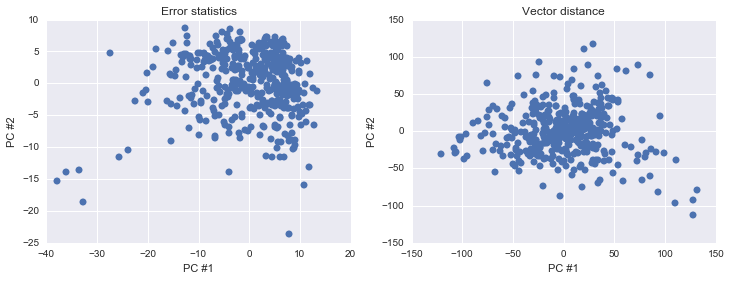

In [4]:
pc_n = 2 # PC count
pca = PCA(n_components=pc_n)
pca_res_avg = pca.fit_transform(err_avg)
pca_res_diff = pca.fit_transform(diff_all)
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.xlabel('PC #1')
plt.ylabel('PC #2')
plt.title('Error statistics')
plt.plot(pca_res_avg[:, 0], pca_res_avg[:, 1], 'o')
plt.subplot(122)
plt.xlabel('PC #1')
plt.ylabel('PC #2')
plt.title('Vector distance')
plt.plot(pca_res_diff[:, 0], pca_res_diff[:, 1], 'o')

# SOM

Testing self-organizing maps (SOM) for vector distance and errors statistics. Cell distance is $D_c(i_1,i_2)=|i_1-i_2|+|j_1-j_2|$. Weight distance is $D_w(w_1,w_2)=\sqrt{\sum_{i}{(w_{1,i}-w_{2,i})^2}}$. Influence function is $H(i)=a(t)\cdot exp\Big(-\frac{D_c(i_{win}, i)}{s(t)}\Big)$ where $a(t)=\frac{1}{t\cdot k_a+1}$, $s(t)=\frac{2}{(t\cdot k_s+1)^2}$, $i_{win}$ is winner index.

In [5]:
d = err_avg
# d = diff_all
m_size = (15, 15) # matrix size
m_len = m_size[0]*m_size[1]
m_index = np.array([[i // m_size[1], i % m_size[1]] for i in range(m_len)]) # indices

# generating initial weights
d_min = np.min(d)
d_max = np.max(d)
w = d_min + (np.random.rand(m_len, d.shape[1]) - 0.5) * (d_max - d_min)

# weight distance
def w_dist(x1, x2):
    return np.sqrt(np.sum(np.square(x1 - x2)))

# cell distance
def m_dist(iv1, iv2):
    m_dist_scale = 2 # cell distance scale
    return (abs(iv1[0] - iv2[0]) + abs(iv1[1] - iv2[1])) * m_dist_scale

# search for winner
def winner_index(x, w_array):
    return np.argmin([w_dist(x, w_array[i]) for i in range(w_array.shape[0])])

# generate influence values
def get_h(winner_idx, t, idx_array):
    a = 1.0 / (t * 5e-4 + 1.0)
    s = 2 * 1.0 / ((t * 2e-3 + 1.0) ** 2)
    return a * np.exp(-np.array([m_dist(idx_array[winner_idx], idx_array[i]) for i in range(idx_array.shape[0])]) / s)

# processing data
for t in log_progress(range(N)):
    x = d[t]
    w_i = winner_index(x, w)
    th = get_h(w_i, t, m_index)
    for i in range(m_len):
        w[i] = w[i] + th[i] * (x - w[i])

## Distance maps

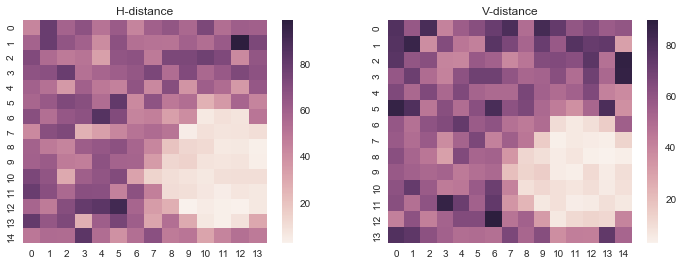

In [6]:
# horizontal and vertical distances
dist_h = np.zeros((m_size[0], m_size[1] - 1))
dist_v = np.zeros((m_size[0] - 1, m_size[1]))
for i in range(m_size[0]):
    for j in range(m_size[1]):
        if i > 0:
            dist_v[i - 1, j] = w_dist(w[(i - 1) * m_size[1] + j], w[i * m_size[1] + j])
        if j > 0:
            dist_h[i, j - 1] = w_dist(w[i * m_size[1] + j - 1], w[i * m_size[1] + j])
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title('H-distance')
sns.heatmap(dist_h)
plt.subplot(122)
plt.title('V-distance')
sns.heatmap(dist_v)

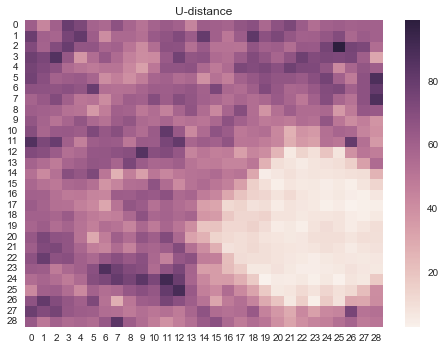

In [9]:
# u-distance as average of neghbors
dist_u = np.zeros((m_size[0] * 2 - 1, m_size[1] * 2 - 1))
for i in range(m_size[0]):
    for j in range(m_size[1]):
        if i < m_size[0] - 1:
            dist_u[i * 2 + 1, j * 2] = w_dist(w[i * m_size[1] + j], w[(i + 1) * m_size[1] + j])
        if j < m_size[1] - 1:
            dist_u[i * 2, j * 2 + 1] = w_dist(w[i * m_size[1] + j], w[i * m_size[1] + j + 1])
def avg4(i ,j):
    s = 0
    n = 0
    if i > 0:
        s += dist_u[i - 1, j]
        n += 1
    if i < dist_u.shape[0] - 1:
        s += dist_u[i + 1, j]
        n += 1
    if j > 0:
        s += dist_u[i, j - 1]
        n += 1
    if j < dist_u.shape[1] - 1:
        s += dist_u[i, j + 1]
        n += 1
    dist_u[i, j] =  s / n
for i in range(m_size[0]):
    for j in range(m_size[1]):
        avg4(i * 2, j * 2)
        if (i < m_size[0] - 1) and (j < m_size[1] - 1):
            avg4(i * 2 + 1, j * 2 + 1)
plt.title('U-distance')
sns.heatmap(dist_u)